# Анализ и обработка данных авиабилетов

## Шаг 1: Загрузка и извлечение данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [ ]:
zip_path = 'Clean_Dataset.csv.zip'
extracted_path = 'Clean_Dataset.csv'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall()

data = pd.read_csv(extracted_path)
data = data.drop(columns=['Unnamed: 0'])
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Шаг 2: Базовый анализ и выявление выбросов

### Описательная статистика

In [ ]:
numeric_cols = data.select_dtypes(include=np.number).columns

In [ ]:
desc_stats = data.describe()
print("Описательная статистика:")
print(desc_stats)

Описательная статистика:
            duration      days_left          price
count  300153.000000  300153.000000  300153.000000
mean       12.221021      26.004751   20889.660523
std         7.191997      13.561004   22697.767366
min         0.830000       1.000000    1105.000000
25%         6.830000      15.000000    4783.000000
50%        11.250000      26.000000    7425.000000
75%        16.170000      38.000000   42521.000000
max        49.830000      49.000000  123071.000000


**Общие характеристики данных:**
- Набор данных содержит 300 153 записей для каждого параметра, что свидетельствует об отсутствии пропусков.

**Длительность (`duration`):**
- Средняя длительность полета: 12.22 часа.
- Минимальная длительность: 0.83 часа (возможно, короткие рейсы или ошибки данных).
- Максимальная длительность: 49.83 часа (дальние международные рейсы с пересадками).
- Разброс (стандартное отклонение): 7.19 часа — значительное разнообразие длительности рейсов.

**Количество дней до вылета (`days_left`):**
- Среднее количество дней до вылета: 26 дней.
- Минимальное значение: 1 день (срочные бронирования).
- Максимальное значение: 49 дней (возможно, ограничение дальнего бронирования).
- Большая часть значений (50% пассажиров) бронирует за 15–38 дней до вылета.

**Цена (`price`):**
- Средняя цена билета: 20,889.66.
- Минимальная цена: 1,105 (выбросы или акции).
- Максимальная цена: 123,071 (премиальные рейсы).
- Разброс (стандартное отклонение): 22,697.77 — цены сильно варьируются.



Теперь оценим выбросы для цены

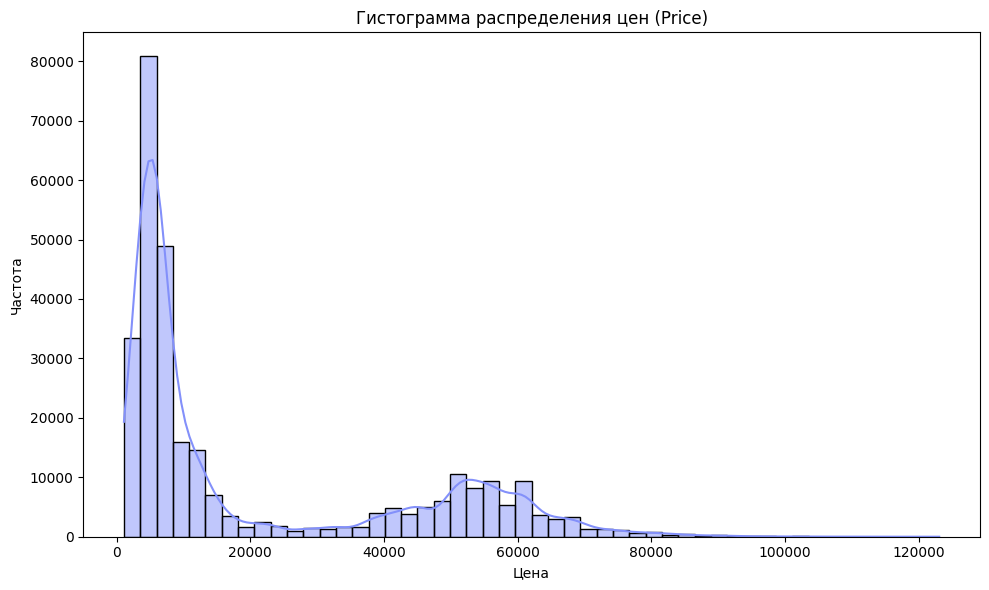

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, color='#8390FA', bins=50)
plt.title('Гистограмма распределения цен (Price)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

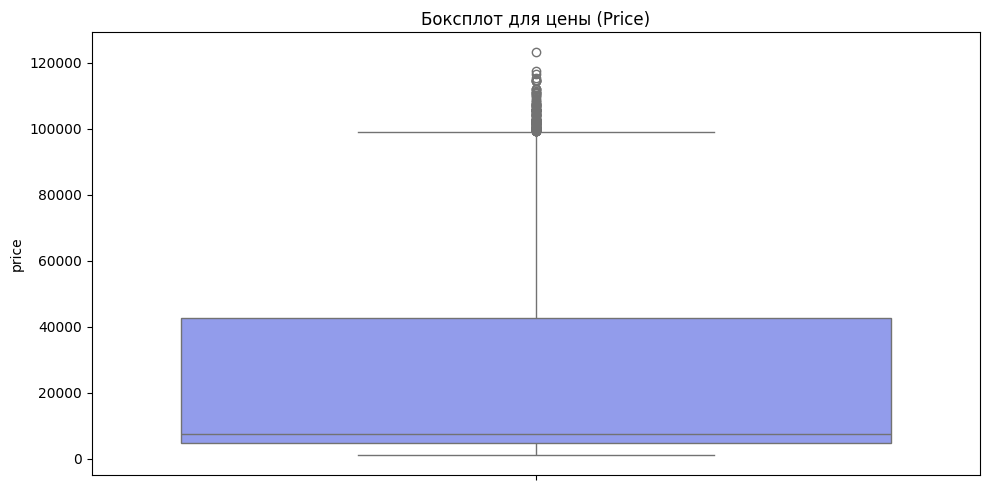

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
sns.boxplot(data['price'], color='#8390FA')
plt.title('Боксплот для цены (Price)')
plt.tight_layout()
plt.savefig('boxplot_price.png')
plt.show()

На графике присутствуют выбросы, которые сильно выше верхней границы "усов" (приблизительно 100,000). Эти выбросы могут быть связаны с премиальными рейсами или необычными ситуациями (например, сильно завышенные цены для отдельных рейсов или акции)

Логарифмирование цены имеет экономическое обоснование, поскольку оно помогает моделировать нелинейные зависимости и снижает влияние экстремальных значений, таких как очень дорогие билеты. Это также делает данные более нормальными, что улучшает результаты анализа и повышает точность моделей. Кроме того, логарифмирование преобразует гистограмму в более симметричное распределение, что делает визуализацию данных более понятной и интерпретируемой.

In [ ]:
data['log_price'] = np.log(data['price'])

Итоговая гистограмма логарифма цены

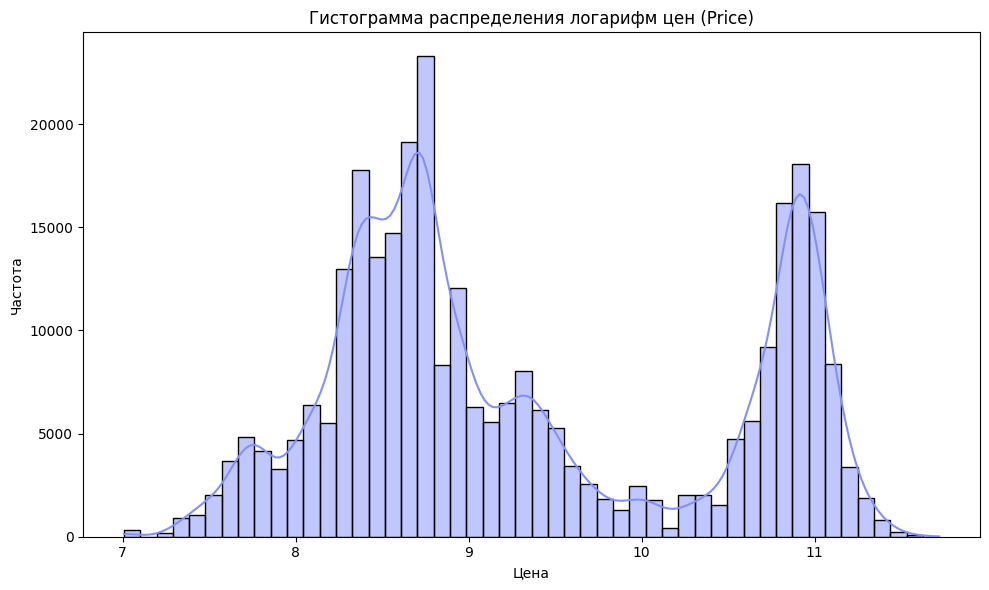

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['log_price'], kde=True, color='#8390FA', bins=50)
plt.title('Гистограмма распределения логарифм цен (Price)')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()

Теперь перейдем к численным объясняющим переменным.

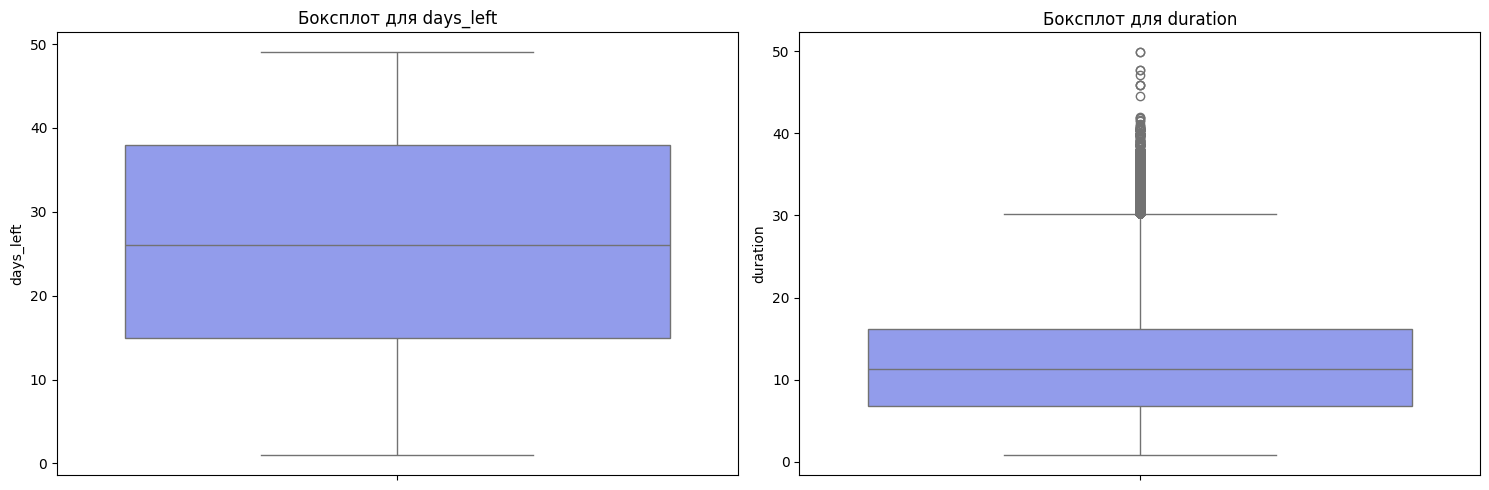

In [ ]:
numeric_cols = ['days_left', 'duration']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(data[col], color='#8390FA')
    plt.title(f'Боксплот для {col}')
    plt.tight_layout()
plt.savefig('3.png')
plt.show()

### Корреляционный анализ

In [ ]:
correlation_matrix = data[['log_price', 'duration', 'days_left']].corr()

print("Корреляционная матрица:")
print(correlation_matrix)

Корреляционная матрица:
           log_price  duration  days_left
log_price   1.000000  0.264296  -0.193535
duration    0.264296  1.000000  -0.039157
days_left  -0.193535 -0.039157   1.000000


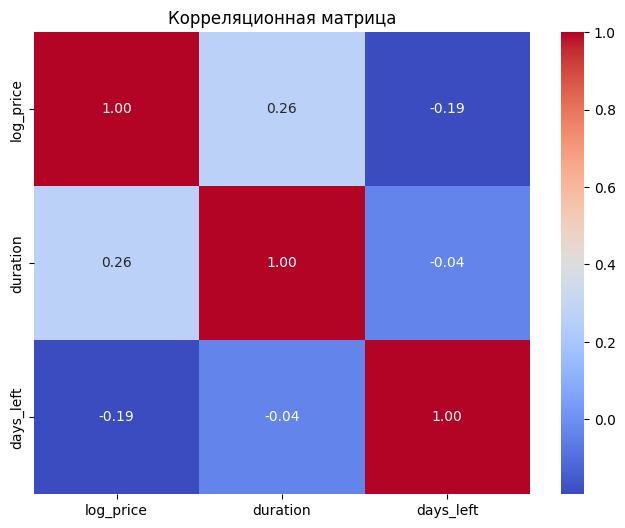

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.savefig('4.png')
plt.show()

1. **Продолжительность рейса (`duration`) и цена (`price`)**:
   - Корреляция составляет **0.26** (умеренная положительная связь).
   - С увеличением длительности рейса цена, как правило, возрастает. Однако связь не очень сильная, что указывает на влияние других факторов на цену.

2. **Количество дней до вылета (`days_left`) и цена (`price`)**:
   - Корреляция составляет **-0.19** (слабая отрицательная связь).
   - Это указывает на небольшую тенденцию к снижению цены при увеличении числа дней до вылета, что отражает политику авиакомпаний предлагать более низкие цены при раннем бронировании.

---

**Основные выводы:**
- Цена авиабилета зависит от продолжительности рейса: чем дольше рейс, тем выше цена.
- Количество дней до вылета оказывает слабое влияние на цену, но наблюдается небольшая тенденция к снижению стоимости при раннем бронировании.


Теперь перейдем к категориальным показателям.

In [ ]:
categorical_cols = ['airline', 'departure_time', 'class', 'arrival_time']

for col in categorical_cols:
    print(f"Распределение категориальных переменных для {col}:")
    print(data[col].value_counts(normalize=True))
    print("\n")


    rare_categories = data[col].value_counts()[data[col].value_counts() < 0.01 * len(data)]
    print(f"Редкие категории в {col}:")
    print(rare_categories)
    print("\n")

Распределение категориальных переменных для airline:
airline
Vistara      0.425979
Air_India    0.269503
Indigo       0.143660
GO_FIRST     0.077204
AirAsia      0.053633
SpiceJet     0.030021
Name: proportion, dtype: float64


Редкие категории в airline:
Series([], Name: count, dtype: int64)


Распределение категориальных переменных для departure_time:
departure_time
Morning          0.237032
Early_Morning    0.222520
Evening          0.216896
Night            0.159968
Afternoon        0.159232
Late_Night       0.004351
Name: proportion, dtype: float64


Редкие категории в departure_time:
departure_time
Late_Night    1306
Name: count, dtype: int64


Распределение категориальных переменных для class:
class
Economy     0.688536
Business    0.311464
Name: proportion, dtype: float64


Редкие категории в class:
Series([], Name: count, dtype: int64)


Распределение категориальных переменных для arrival_time:
arrival_time
Night            0.304971
Evening          0.260944
Morning          0

Теперь будем работать с столбцами 'Source City' и 'Destination City'

In [ ]:
source_city_counts = data['source_city'].value_counts()
destination_city_counts = data['destination_city'].value_counts()

print("Топ 3 городов вылета:")
print(source_city_counts.head(3))

print("Топ 3 городов назначения:")
print(destination_city_counts.head(3))

Топ 3 городов вылета:
source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Name: count, dtype: int64
Топ 3 городов назначения:
destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Name: count, dtype: int64


In [ ]:
city_counts = source_city_counts.add(destination_city_counts, fill_value=0)

top_3_cities = city_counts.nlargest(3).index

data['Top_3_City'] = data['source_city'].apply(lambda x: 1 if x in top_3_cities else 0) + \
                      data['destination_city'].apply(lambda x: 1 if x in top_3_cities else 0)

# Если город в обоих столбцах (выезд и назначение), то переменная будет больше 1
# Можно привести переменную к значениям 1 или 0
data['Top_3_City'] = data['Top_3_City'].apply(lambda x: 1 if x > 0 else 0)


print(data[['source_city', 'destination_city', 'Top_3_City']].head())

  source_city destination_city  Top_3_City
0       Delhi           Mumbai           1
1       Delhi           Mumbai           1
2       Delhi           Mumbai           1
3       Delhi           Mumbai           1
4       Delhi           Mumbai           1


Теперь проделаем схожую процедуру с количеством отстановок

В анализе данных о рейсах переменная "Stops" указывает на количество пересадок, которые делает рейс. Эта переменная может принимать одно из трех значений: 'zero' (без пересадок), 'one' (одна пересадка) и 'two_or_more' (две или более пересадки). Однако для упрощения анализа и создания бинарной классификации было решено создать дамми-переменную Has_Stops, которая будет указывать, имеется ли пересадка в рейсе или нет.

Новая переменная Has_Stops принимает значение 1, если рейс включает хотя бы одну пересадку (то есть если значение в столбце "Stops" равно 'one' или 'two_or_more'), и 0, если рейс не имеет пересадок (значение 'zero'). Это упрощает дальнейший анализ, позволяя выделить рейсы с пересадками и без них и исследовать их влияние на цену билета и другие характеристики рейса.

In [ ]:
unique_stops = data['stops'].nunique()

print(f"Количество уникальных значений в переменной 'Stops': {unique_stops}")

unique_stop_values = data['stops'].unique()
print(f"Уникальные значения в переменной 'Stops': {unique_stop_values}")

Количество уникальных значений в переменной 'Stops': 3
Уникальные значения в переменной 'Stops': ['zero' 'one' 'two_or_more']


In [ ]:
data['Has_Stops'] = data['stops'].apply(lambda x: 1 if x != 'zero' else 0)

# Построение линейной регрессии

Преобразуем категориальные переменные в дамми

In [ ]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

data = data[['airline', 'departure_time', 'class', 'arrival_time', 'duration', 'days_left', 'log_price', 'Has_Stops','Top_3_City']]
categorical_columns = ['airline', 'departure_time', 'class', 'arrival_time']

data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data_encoded['Has_Stops'] = data_encoded['Has_Stops'].astype(int)
for col in data_encoded.select_dtypes(include=['bool']).columns:
    data_encoded[col] = data_encoded[col].astype(int)

data_encoded = data_encoded.dropna()

X = data_encoded.drop(columns=['log_price'])
y = data_encoded['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train)

model_sm = sm.OLS(y_train, X_train_sm).fit()

print("\nОсновные метрики модели:")
print(f"R-squared (Коэффициент детерминации): {model_sm.rsquared:.2f}")
print(f"Adjusted R-squared (Скорректированный R^2): {model_sm.rsquared_adj:.2f}")



print("\nПодробное описание модели:")
print(model_sm.summary())


y_pred = model_sm.predict(sm.add_constant(X_test))




Основные метрики модели:
R-squared (Коэффициент детерминации): 0.91
Adjusted R-squared (Скорректированный R^2): 0.91

Подробное описание модели:
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                 1.182e+05
Date:                Fri, 13 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:47:42   Log-Likelihood:                -80139.
No. Observations:              240122   AIC:                         1.603e+05
Df Residuals:                  240101   BIC:                         1.605e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t   

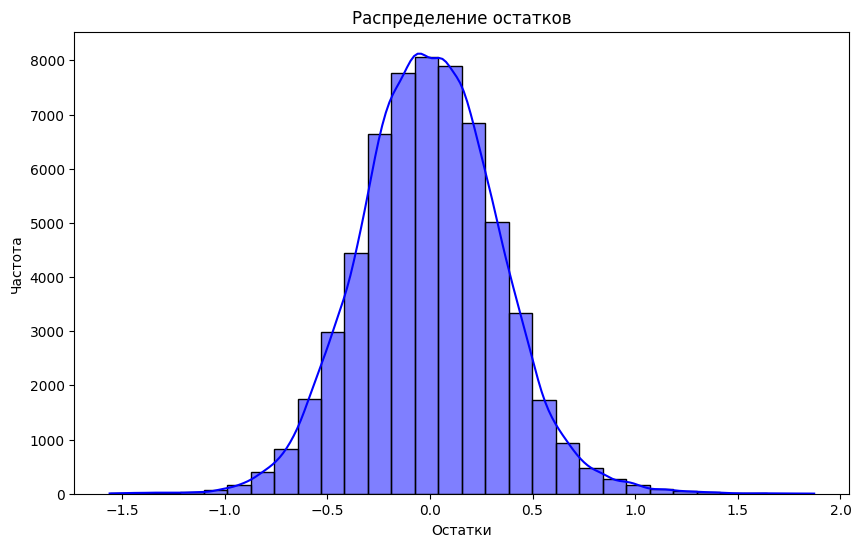

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Распределение остатков")
plt.xlabel("Остатки")
plt.ylabel("Частота")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
from io import StringIO

model_sm = sm.OLS(y_train, sm.add_constant(X_train)).fit()

with PdfPages('regression_results.pdf') as pdf:

    plt.figure(figsize=(8, 6))
    text_metrics = f"R-squared (Коэффициент детерминации): {model_sm.rsquared:.2f}\n" \
                   f"Adjusted R-squared (Скорректированный R^2): {model_sm.rsquared_adj:.2f}\n"
    plt.text(0.1, 0.5, text_metrics, fontsize=12, wrap=True)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    result_text = model_sm.summary().as_text()

    plt.figure(figsize=(8, 6))
    plt.text(0.1, 0.5, result_text, fontsize=10, wrap=True)
    plt.axis('off')
    pdf.savefig()
    plt.close()

print("Результаты регрессии сохранены в файл regression_results.pdf")


Результаты регрессии сохранены в файл regression_results.pdf


In [ ]:
!pip install stargazer

In [ ]:
from stargazer.stargazer import Stargazer

stargazer = Stargazer([model_sm])

with open('regression_results.tex', 'w') as f:
    f.write(stargazer.render_latex())


In [ ]:
model = sm.OLS(y, X).fit()
t_values = model.tvalues

threshold = np.sqrt(n)

filtered_columns = [col for col, t_val in zip(X.columns, t_values) if abs(t_val) > threshold]
X_filtered = X[filtered_columns]

model_filtered = sm.OLS(y, X_filtered).fit()

stargazer = Stargazer([model_filtered])
latex_output = stargazer.render_latex()
print(latex_output)

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: log_price}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 class_Economy & -2.183$^{***}$ \\
& (0.002) \\
 const & 10.834$^{***}$ \\
& (0.002) \\
\hline \\[-1.8ex]
 Observations & 300153 \\
 $R^2$ & 0.826 \\
 Adjusted $R^2$ & 0.826 \\
 Residual Std. Error & 0.465 (df=300151) \\
 F Statistic & 1420906.942$^{***}$ (df=1; 300151) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}
